Generative AI was not used to support completion of this assessment.

Introduction

This project builds a text classification system to predict the severity of side effects from a written review. This is done using the Drug Review dataset available from UCI here: https://archive.ics.uci.edu/dataset/461/drug+review+dataset+druglib+com

From this we use the sideEffectsReviews column made up of free-text to predict the sideEffects from "No Side Effects" to "Extremely Severe Side Effects". Automating this process helps prevent manually reading thousands of reviews and assigning a severity.

The data has a large class imbalance as some side effect categories are rarer than others. To combat this imbalance class weights are calculated and used in the models.

The pipeline used follows a standard bag-of-words approach; tokenisation, stop word removal, lower case normalisation and TF-IDF to represent the text. This is followed by a linear Support Vector Machine (SVM) and a small neural Multi-Layer Perceptron (MLP).

Representation Learning

The sideEffectsReviews text is converted into numerical vectors with the use of TF-IDF. During pre-processing each review is tokenised with NLTK. The tokens are all normalised to be lower case, then puncuation / non-alphabetic tokens are removed alongside the English stop-words gathered from an NLTK stopwords import. The tokens are then rejoined into cleaned strings.

Then a TF-IDF Vectorizer is fitted with training data only to avoid leakage. The TF-IDF then assigns weights to each word, frequent uninformative words having a lower weight. While the SVM can work with the output directly, to work for the MLP the data is converted with .todense() after the TF-IDF is built.

The sideEffect labels originally defined like "Severe Side Effects" are mapped to integers (0-4) via a dictionary built from the unique values, this is to ensure consistency across the train and test sets.

Algorithms

The two algorithms compared for this text classification pipeline are Multi-Layer Perceptron (MLP) and Support Vector Machine (SVM).


MLP is made up of an input layer, one or more hidden layers and an output layer.
Once the text from the dataset is converted into a vector, it is often a simple multi-value vector with a single single label. In the case of this program it is not. Therefore we must adapt the MLP.

For the input layer a numerical vector is taken in, with the size of the input layer being the number of indexes in the vector. In this program the input layer is determined by the number of TF-IDF features.

The hidden layer (in this program there are 2) is connected to input and output layers using weights and biases. Each hidden layer can have a different activation function.

For output Softmax is used for classification, the output is therefore a vector of probabilities which is the same length as the number of classes.


SVM is the second model in the program. It attempts to find a hyperplane that distinctly classifies data points. The SVM in this program is an example of a soft margin which combines with a loss function to learn non-linear seperation.

SVMs are by default a binary classifier. However they can be easily adapted for multi-class use. In this case a SVC is used which is from the sklearn import that is designed specifically for categorical classification use.

A Multi-Class SVM breaks down multiple classes into multiple binary classifications, then identifies multiple hyperplanes to seperate each binary classification.

Evaluation

The models are both tested using the drugLibTest_raw file. For each model the accuracy and a weighted-average F1 score is computed. The Accuracy summarises overall correctness but due to the class imbalance can be misleading. The weighted F1 score cobmines precision and recall per class, weighting by support, which is a better reflection of performance on both frequent and rare side-effect categories.

A classification report is generated for both models with per-class precision, recall, F1, and support to spot errors. To provide more insight a table made from correct/incorrect predictions per class is created. This helps identify which labels are the hardest. At the very end a bar chart was created to compare both the models on accuracy and weighted F1 score for visual representation.

In this particular setup the linear SVM performs better than the MLP on both accuracy and weighted F1 score, while class weighting helps both models perform better the main source of issue remains the minority labels. For potential improvements, data augmentation or deep transfer learning could be viable solutions to improve the models.

In [ ]:
#imports
import os
from google.colab import files
import pandas as pd
import sklearn
import io

from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt


SECTION 1: DATASET

Loading and Exploring the Data

In [ ]:
# #Mounting the Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # Checking directories of dataset
# main_dr_path = '/content/drive/MyDrive/Colab Notebooks/NLP_COURSEWORK/drug+review'
# print(os.listdir(main_dr_path))

In [ ]:
# #Set train and test
# train_file = '/content/drive/MyDrive/Colab Notebooks/NLP_COURSEWORK/drug+review/drugLibTrain_raw.tsv'
# test_file = '/content/drive/MyDrive/Colab Notebooks/NLP_COURSEWORK/drug+review/drugLibTest_raw.tsv'

In [ ]:
#Uploading Train File
uploaded = files.upload()
sentiment_file = io.BytesIO(uploaded['drugLibTrain_raw.tsv'])
train_data = pd.read_csv(sentiment_file, sep='\t', dtype={'sideEffectsReview': str, 'sideEffects': str})

Saving drugLibTrain_raw.tsv to drugLibTrain_raw.tsv


In [ ]:
#Viewing train data
df_train = pd.DataFrame(train_data)
print(df_train)

      Unnamed: 0       urlDrugName  rating           effectiveness  \
0           2202         enalapril       4        Highly Effective   
1           3117  ortho-tri-cyclen       1        Highly Effective   
2           1146           ponstel      10        Highly Effective   
3           3947          prilosec       3    Marginally Effective   
4           1951            lyrica       2    Marginally Effective   
...          ...               ...     ...                     ...   
3102        1039           vyvanse      10        Highly Effective   
3103        3281            zoloft       1             Ineffective   
3104        1664           climara       2    Marginally Effective   
3105        2621         trileptal       8  Considerably Effective   
3106        2748          micardis       4    Moderately Effective   

                        sideEffects                               condition  \
0                 Mild Side Effects  management of congestive heart failure   
1

In [ ]:
#Uploading Test File
uploaded = files.upload()
sentiment_file = io.BytesIO(uploaded['drugLibTest_raw.tsv'])
test_data = pd.read_csv(sentiment_file, sep='\t', dtype={'sideEffectsReview': str, 'sideEffects': str})

Saving drugLibTest_raw.tsv to drugLibTest_raw.tsv


In [ ]:
#Viewing test data
df_test = pd.DataFrame(test_data)
print(df_test)

      Unnamed: 0     urlDrugName  rating           effectiveness  \
0           1366          biaxin       9  Considerably Effective   
1           3724        lamictal       9        Highly Effective   
2           3824        depakene       4    Moderately Effective   
3            969         sarafem      10        Highly Effective   
4            696        accutane      10        Highly Effective   
...          ...             ...     ...                     ...   
1031         690        accutane       7  Considerably Effective   
1032        1071      proair-hfa      10        Highly Effective   
1033         681        accutane       8  Considerably Effective   
1034        2709         divigel      10        Highly Effective   
1035         729  claripel-cream       8  Considerably Effective   

                sideEffects                          condition  \
0         Mild Side Effects                    sinus infection   
1         Mild Side Effects                   bipol

In [ ]:
#Assigning x and y

#Train
x_train = list(df_train['sideEffectsReview'])
y_train = list(df_train['sideEffects'])

#Test
x_test = list(df_test['sideEffectsReview'])
y_test = list(df_test['sideEffects'])

In [ ]:
# Count the instances of each class in the training data
train_class_counts = pd.Series(y_train).value_counts()
print("Training data class distribution:")
print(train_class_counts)

print("\n" + "=================================================" + "\n")

# Count the instances of each class in the testing data
test_class_counts = pd.Series(y_test).value_counts()
print("Testing data class distribution:")
print(test_class_counts)

Training data class distribution:
Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: count, dtype: int64


Testing data class distribution:
Mild Side Effects                330
No Side Effects                  268
Moderate Side Effects            236
Severe Side Effects              122
Extremely Severe Side Effects     80
Name: count, dtype: int64


Pre-Processing

In [ ]:
# Map the y values to integers (0-4)
unique_y_values = np.unique(y_train)
# Create a mapping from string labels to integers
y_mapping = {label: i for i, label in enumerate(unique_y_values)}

print("Mapping of y values to integers:", y_mapping)

Mapping of y values to integers: {np.str_('Extremely Severe Side Effects'): 0, np.str_('Mild Side Effects'): 1, np.str_('Moderate Side Effects'): 2, np.str_('No Side Effects'): 3, np.str_('Severe Side Effects'): 4}


In [ ]:
# Convert y_train and y_test to numeric using the y_mapping
y_train_numeric = [y_mapping[label] for label in y_train]
y_test_numeric = [y_mapping[label] for label in y_test]

Assign weights to classes due to imbalance in data

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#Calculate weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_numeric), y=y_train_numeric)
class_weight_dict = dict(enumerate(class_weights))

#Viewing the weights
print("Class weights:")
for class_index, weight in class_weight_dict.items():
    class_name = [label for label, index in y_mapping.items() if index == class_index][0]
    print(f"  Class '{class_name}': {weight}")

Class weights:
  Class 'Extremely Severe Side Effects': 3.5508571428571427
  Class 'Mild Side Effects': 0.6098135426889107
  Class 'Moderate Side Effects': 1.0120521172638437
  Class 'No Side Effects': 0.6681720430107527
  Class 'Severe Side Effects': 1.684010840108401


In [ ]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def prep(sentences):
  prep_text = []
  for sent in sentences:
    sent = str(sent)
    token_text = word_tokenize(sent)
    normd_text = [token.lower() for token in token_text if token.isalpha()]

    swr_text = [token for token in normd_text if token not in stopwords.words('english')]

    prep_text.append(" ".join(swr_text))

  return prep_text

In [ ]:
#View processed x_train
x_train_prepped = prep(x_train)
print(x_train_prepped)

['cough hypotension proteinuria impotence renal failure angina pectoris tachycardia eosinophilic pneumonitis tastes disturbances anusease anorecia weakness fatigue insominca weakness', 'heavy cycle cramps hot flashes fatigue long lasting cycles months concidering changing different bc first time using kind bc unfortunately due constant hassel happy results', 'heavier bleeding clotting normal', 'constipation dry mouth mild dizziness would go away medication stopped days', 'felt extremely drugged dopey could drive med also extreme ankle feet swelling could even wear shoes', 'low sex drive started taking drug years age full enthousiasm engaged years old sex drive low wife unsatisfied also tired even peak hours throughout day hard concentrate mundain tasks', 'experiences nausiea heavy moodswings days take decreased appetite negative affect memory', 'none', 'really side effects mild tolerable issue taking times day effect way need take first within first day couple weeks starting medicine b

In [ ]:
#Pre-Processing x train and tests
x_train_prepped = prep(x_train)
x_test_prepped = prep(x_test)

SECTION 2: REPRESENTATION LEARNER

Representation Learner - TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_base = TfidfVectorizer(max_features = 5000)

acc_score = []

#copy a blank tfidf so there is no leakage
tfidf = tfidf_base

x_train_tfidf = tfidf.fit_transform(x_train_prepped)
x_train_tfidf = x_train_tfidf.todense()

x_test_tfidf = tfidf.transform(x_test_prepped)
x_test_tfidf = x_test_tfidf.todense()

num_features = x_train_tfidf.shape[1]

SECTION 3: ALGORITHMS

Configuring and Training the model

In [ ]:
def mlp(dataset_size, num_classes):
  input_shape = (dataset_size,)

  model = Sequential()
  model.add(Dense(128, input_shape=input_shape, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

In [ ]:
model = mlp(num_features, len(unique_y_values))

y_test_categorical = to_categorical(y_test_numeric, num_classes=len(unique_y_values))


# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train_tfidf, to_categorical(y_train_numeric, num_classes=len(unique_y_values)), epochs=10, batch_size=250, verbose=1, validation_split=0.2, class_weight=class_weight_dict)

# Test the model after training
test_results = model.evaluate(x_test_tfidf, y_test_categorical, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

acc_score.append(test_results[1])

print("Accuracy:", np.mean(acc_score))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.2401 - loss: 1.6285 - val_accuracy: 0.4164 - val_loss: 1.5915
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6385 - loss: 1.5662 - val_accuracy: 0.5289 - val_loss: 1.5358
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7183 - loss: 1.4651 - val_accuracy: 0.5579 - val_loss: 1.4263
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7586 - loss: 1.2987 - val_accuracy: 0.5707 - val_loss: 1.2560
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8087 - loss: 1.0379 - val_accuracy: 0.5740 - val_loss: 1.1115
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8551 - loss: 0.7739 - val_accuracy: 0.5820 - val_loss: 1.0507
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8851 - loss: 0.5371 - val_accuracy: 0.5611 - val_loss: 1.0586
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9135 - loss: 0.3874 - val_accuracy: 0.5611 - 

SVC Algorithm

In [ ]:
# Initialize and train the SVM model with class weights
svm_model = SVC(kernel='linear', random_state=42, class_weight=class_weight_dict)
svm_model.fit(np.asarray(x_train_tfidf), y_train_numeric)

# Make predictions test data
y_pred_svm = svm_model.predict(np.asarray(x_test_tfidf))

# Evaluate model
print("SVM Model Performance:")
print("Accuracy:", accuracy_score(y_test_numeric, y_pred_svm))

SVM Model Performance:
Accuracy: 0.5617760617760618


-------------- RESULT VIEWING ------------------

SECTION 4: EVALUATION

In [ ]:
#Make predictions from model
predictions = model.predict(x_test_tfidf)
pred_labels = np.where(predictions>0.5, 1, 0)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
from sklearn.metrics import classification_report

y_test_single = y_test_numeric

# Get the predicted class labels from the MLP model
pred_labels_mlp = np.argmax(predictions, axis=1)

predicted_labels = pred_labels_mlp

results = pd.DataFrame({'Actual_encoded': y_test_single, 'Predicted_encoded': predicted_labels})

#Create a list of target names
actual_class_names = [label for label, encoded in sorted(y_mapping.items(), key=lambda item: item[1])]

#Create a list to store the results for each class
class_performance = []

for class_encoded, class_name in enumerate(actual_class_names):
    class_results = results[results['Actual_encoded'] == class_encoded]

    #Count correct predictions for the current class
    correct_predictions = class_results[class_results['Actual_encoded'] == class_results['Predicted_encoded']].shape[0]

    #Count incorrect predictions for the current class
    incorrect_predictions = class_results[class_results['Actual_encoded'] != class_results['Predicted_encoded']].shape[0]

    #Get the total number of instances for the current class
    total_instances = class_results.shape[0]

    #Append the results to list
    class_performance.append({
        'Class Name': class_name,
        'Correctly Predicted': correct_predictions,
        'Incorrectly Predicted': incorrect_predictions,
        'Total Instances': total_instances
    })

#Create dataframe and display
class_performance_df = pd.DataFrame(class_performance)
display(class_performance_df)

#Create a list of target names in the correct order based on y_mapping
target_names = [label for label, encoded in sorted(y_mapping.items(), key=lambda item: item[1])]

print(classification_report(y_test_numeric, pred_labels_mlp, target_names=target_names))

,Class Name,Correctly Predicted,Incorrectly Predicted,Total Instances
0,Extremely Severe Side Effects,23,57,80
1,Mild Side Effects,192,138,330
2,Moderate Side Effects,99,137,236
3,No Side Effects,200,68,268
4,Severe Side Effects,48,74,122


                               precision    recall  f1-score   support

Extremely Severe Side Effects       0.44      0.29      0.35        80
            Mild Side Effects       0.55      0.58      0.57       330
        Moderate Side Effects       0.41      0.42      0.41       236
              No Side Effects       0.81      0.75      0.78       268
          Severe Side Effects       0.33      0.39      0.36       122

                     accuracy                           0.54      1036
                    macro avg       0.51      0.49      0.49      1036
                 weighted avg       0.55      0.54      0.54      1036



In [ ]:
y_test_single = y_test_numeric

predicted_labels = y_pred_svm

results = pd.DataFrame({'Actual_encoded': y_test_single, 'Predicted_encoded': predicted_labels})

#Create a list of target names
actual_class_names = [label for label, encoded in sorted(y_mapping.items(), key=lambda item: item[1])]

#Create a list to store the results for each class
class_performance = []

for class_encoded, class_name in enumerate(actual_class_names):
    class_results = results[results['Actual_encoded'] == class_encoded]

    #Count correct predictions for the current class
    correct_predictions = class_results[class_results['Actual_encoded'] == class_results['Predicted_encoded']].shape[0]

    #Count incorrect predictions for the current class
    incorrect_predictions = class_results[class_results['Actual_encoded'] != class_results['Predicted_encoded']].shape[0]

    #Get the total number of instances for the current class
    total_instances = class_results.shape[0]

    #Append the results to list
    class_performance.append({
        'Class Name': class_name,
        'Correctly Predicted': correct_predictions,
        'Incorrectly Predicted': incorrect_predictions,
        'Total Instances': total_instances
    })

#Create dataframe and display
class_performance_df = pd.DataFrame(class_performance)
display(class_performance_df)

# Display the classification report for the SVM model
print("\nClassification Report for SVM Model:")
print(classification_report(y_test_numeric, y_pred_svm, target_names=target_names))

,Class Name,Correctly Predicted,Incorrectly Predicted,Total Instances
0,Extremely Severe Side Effects,27,53,80
1,Mild Side Effects,198,132,330
2,Moderate Side Effects,102,134,236
3,No Side Effects,198,70,268
4,Severe Side Effects,57,65,122



Classification Report for SVM Model:
                               precision    recall  f1-score   support

Extremely Severe Side Effects       0.45      0.34      0.39        80
            Mild Side Effects       0.59      0.60      0.59       330
        Moderate Side Effects       0.43      0.43      0.43       236
              No Side Effects       0.83      0.74      0.78       268
          Severe Side Effects       0.35      0.47      0.40       122

                     accuracy                           0.56      1036
                    macro avg       0.53      0.52      0.52      1036
                 weighted avg       0.58      0.56      0.57      1036



Creating a bar chart for model comparison

In [ ]:
#Generate classification report for MLP model in dictionary format
mlp_report = classification_report(y_test_numeric, pred_labels_mlp, target_names=target_names, output_dict=True)

#Extract accuracy
mlp_accuracy = mlp_report['accuracy']

#Extract F1-score
mlp_f1_score = mlp_report['weighted avg']['f1-score']

#View outputs
print(f"MLP Model Accuracy: {mlp_accuracy}")
print(f"MLP Model Weighted Avg F1-score: {mlp_f1_score}")

MLP Model Accuracy: 0.5424710424710425
MLP Model Weighted Avg F1-score: 0.5445739541799711


In [ ]:
#Generate classification report for SVM model in dictionary format
svm_report = classification_report(y_test_numeric, y_pred_svm, target_names=target_names, output_dict=True)

#Extract accuracy
svm_accuracy = svm_report['accuracy']

#Extract weighted average F1-score
svm_f1_score = svm_report['weighted avg']['f1-score']

#View outputs
print(f"SVM Model Accuracy: {svm_accuracy}")
print(f"SVM Model Weighted Avg F1-score: {svm_f1_score}")

SVM Model Accuracy: 0.5617760617760618
SVM Model Weighted Avg F1-score: 0.5662213237677679


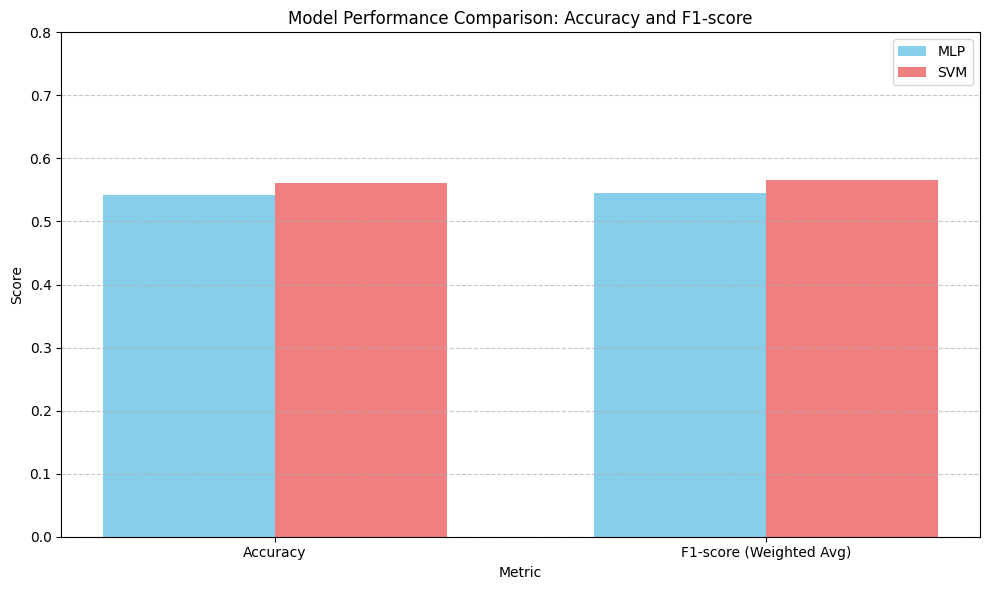

In [ ]:
#Metrics to compare
metric_labels = ['Accuracy', 'F1-score (Weighted Avg)']
mlp_scores = [mlp_accuracy, mlp_f1_score]
svm_scores = [svm_accuracy, svm_f1_score]


plt.figure(figsize=(10, 6))
bar_width = 0.35

#Set the x-axis positions for the groups of bars
x = np.arange(len(metric_labels))

#Plot bars for MLP
plt.bar(x - bar_width/2, mlp_scores, bar_width, label='MLP', color='skyblue')

#Plot bars for SVM
plt.bar(x + bar_width/2, svm_scores, bar_width, label='SVM', color='lightcoral')

#Add labels, title, and legend
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Comparison: Accuracy and F1-score')
plt.xticks(x, metric_labels)
plt.legend()
plt.ylim(0, 0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()